In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import astropy.units as u


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'


In [3]:
# Each row is an individual ZTF detection, each column is a field describing that detection
alerts = pd.concat((
    pd.read_csv("../BTS_data/train_cand_N100.csv", index_col=None),
    pd.read_csv("../BTS_data/val_cand_N100.csv", index_col=None),
    pd.read_csv("../BTS_data/test_cand_N100.csv", index_col=None)
))

# Each row is a ZTF source
# important columns here like redshift, type, etc.
sources = pd.read_csv("../BTS_data/explorer.csv", index_col=None)

In [4]:
# we want some features that are not already present in the alerts
alerts[['redshift', 'A_V']] = -1
alerts['type'] = '-'

In [5]:
sources = sources[sources['ZTFID'].isin(alerts['objectId'])]
sources = sources[~sources['type'].isin(['-'])]

alerts = alerts[alerts['objectId'].isin(sources['ZTFID'])]

alerts.reset_index(inplace=True)

In [6]:
for s_idx in tqdm(sources.index):
    objid = sources.loc[s_idx, "ZTFID"]
    obj_alerts = alerts.loc[alerts['objectId'] == objid]
    
#     print(objid, len(obj_alerts))
    
    # Transfer necessary columns
    alerts.loc[alerts['objectId'] == objid, "redshift"] = sources.loc[s_idx, "redshift"]
    alerts.loc[alerts['objectId'] == objid, "type"]     = sources.loc[s_idx, "type"]
    alerts.loc[alerts['objectId'] == objid, "A_V"]      = sources.loc[s_idx, "A_V"]

  0%|                                                                                | 0/7904 [00:00<?, ?it/s]/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_7796/2894114544.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  alerts.loc[alerts['objectId'] == objid, "redshift"] = sources.loc[s_idx, "redshift"]
/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_7796/2894114544.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.827' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  alerts.loc[alerts['objectId'] == objid, "A_V"]      = sources.loc[s_idx, "A_V"]
100%|█████████████████████████████████████████████████████████████████████| 7904/7904 [04:10<00:00, 31.50it/s]


In [7]:
# alerts['flux'] = alerts['magpsf'].to_numpy()*u.ABmag.to(u.erg/u.s/u.cm**2/u.Hz)

alerts['flux'] = 10**(-0.4*(alerts['magpsf']-alerts['magzpsci']))
alerts['fluxErr'] = np.abs(alerts['flux']*alerts['sigmapsf'] * (np.log(10) / 2.5))
alerts['passband'] = ['g' if alerts.loc[a_idx, 'fid'] == 1 else 'r' for a_idx in alerts.index]


In [8]:
alerts.to_csv("../BTS_data/ZTF_alerts.csv", index=None)

In [9]:
alerts = pd.read_csv("../BTS_data/ZTF_alerts.csv", index_col=None)
alerts

,index,objectId,jd,label,fid,diffmaglim,programid,candid,isdiffpos,field,...,split,is_SN,near_threshold,is_rise,redshift,A_V,type,flux,fluxErr,passband
0,3,ZTF22abgteub,2.459848e+06,1,2,20.742260,1,2093244285915015013,True,734,...,train,True,False,True,0.051,0.683,SN Ia,1132.400602,79.470112,r
1,4,ZTF20aauhbvu,2.459061e+06,1,2,20.636539,1,1306405371415015006,True,851,...,train,True,False,False,0.0048,1.022,SN IIP,1836.541312,98.442206,r
2,6,ZTF20abbihor,2.459002e+06,1,1,19.545223,1,1247181204115015004,True,842,...,train,True,False,True,0.04,0.090,SN Ia,3512.368941,118.460435,g
3,7,ZTF23aanptpp,2.460119e+06,1,1,20.162737,1,2364405910915015013,True,850,...,train,True,False,True,0.104,0.517,SLSN-II,983.556646,87.830106,g
4,9,ZTF20abrnavu,2.459077e+06,1,2,20.396652,1,1322376313615015006,True,394,...,train,True,True,True,0.08,0.078,SN Ia,594.840225,48.279830,r
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208817,49720,ZTF19acecluy,2.458861e+06,1,2,18.959240,1,1106352596015015001,True,366,...,test,True,False,False,0.01,0.100,SN II,634.454099,122.618237,r
208818,49723,ZTF23aaejumk,2.460054e+06,0,1,20.732084,1,2299472614715015001,True,763,...,test,True,False,True,0.02442,0.035,SN II,595.936369,76.861687,g
208819,49724,ZTF19aarqmjs,2.458599e+06,1,2,19.793480,1,844145336115015002,True,362,...,test,True,False,True,0.055,0.158,SN Ia,498.424971,63.778791,r
208820,49728,ZTF19abjmnlw,2.460147e+06,0,2,20.253988,1,2392377020115015002,True,340,...,test,False,False,False,-,0.090,AGN,651.628302,71.858242,r


<ErrorbarContainer object of 3 artists>

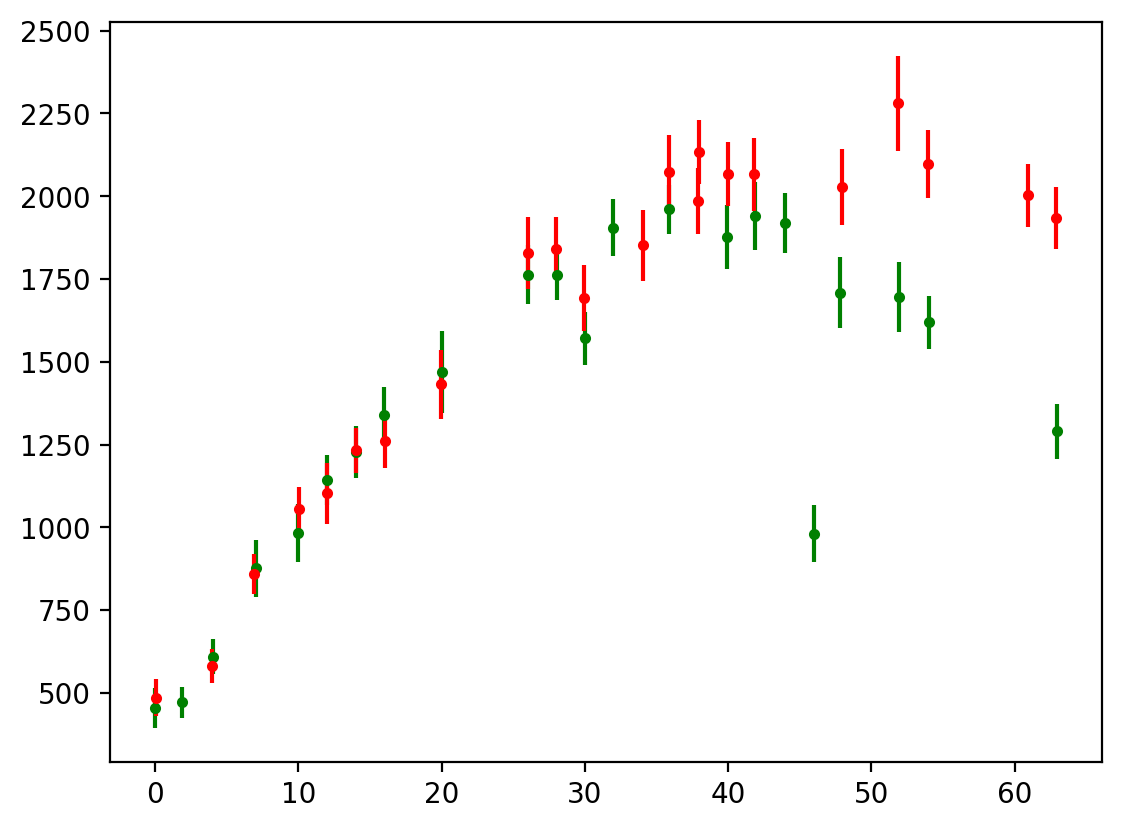

In [16]:
objid = "ZTF23aanptpp"

obj_alerts = alerts[alerts['objectId'] == objid]

gband = obj_alerts['fid'] == 1
rband = obj_alerts['fid'] == 2

plt.errorbar(obj_alerts[gband]['age'], obj_alerts[gband]['flux'], yerr=obj_alerts[gband]['fluxErr'], c='g', fmt='.')
plt.errorbar(obj_alerts[rband]['age'], obj_alerts[rband]['flux'], yerr=obj_alerts[rband]['fluxErr'], c='r', fmt='.')

# plt.gca().invert_yaxis()

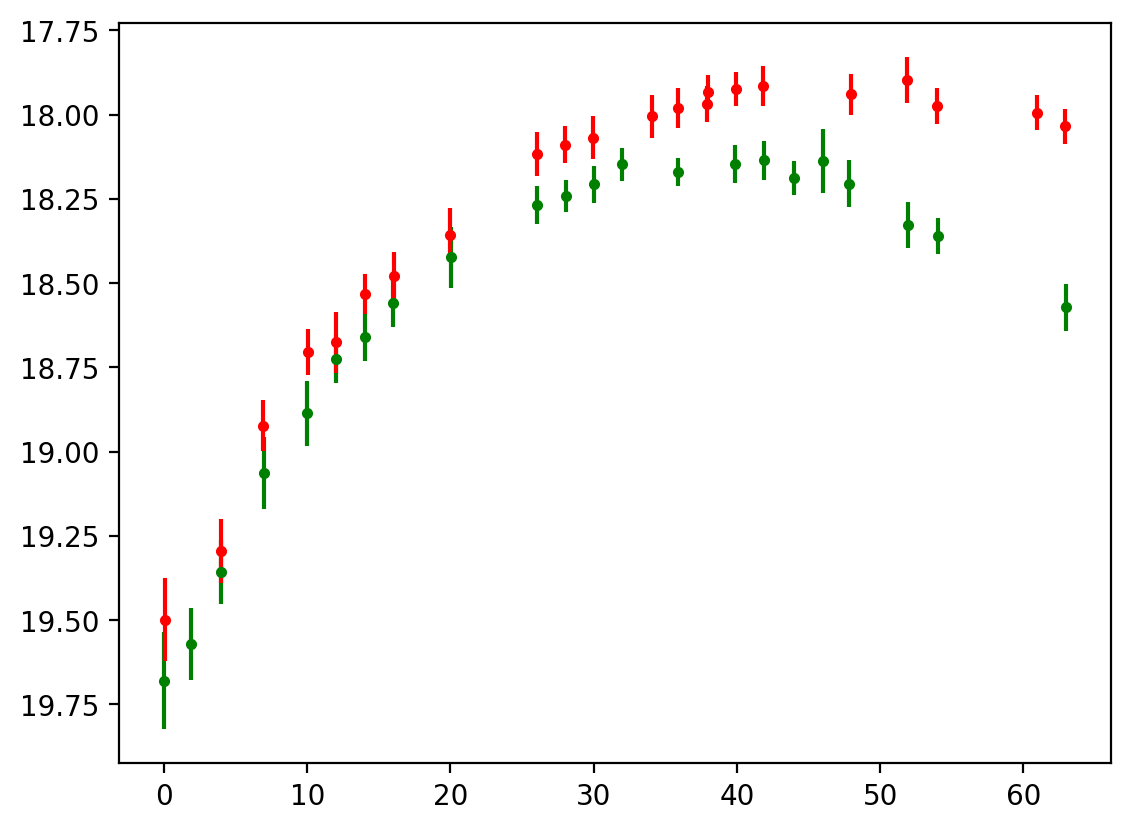

In [15]:
objid = "ZTF23aanptpp"

obj_alerts = alerts[alerts['objectId'] == objid]

gband = obj_alerts['fid'] == 1
rband = obj_alerts['fid'] == 2

plt.errorbar(obj_alerts[gband]['age'], obj_alerts[gband]['magpsf'], yerr=obj_alerts[gband]['sigmapsf'], c='g', fmt='.')
plt.errorbar(obj_alerts[rband]['age'], obj_alerts[rband]['magpsf'], yerr=obj_alerts[rband]['sigmapsf'], c='r', fmt='.')

plt.gca().invert_yaxis()